In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

##Download Dataset

In [ ]:
# Install Kaggle
# !pip install kaggle

# Upload your kaggle.json file
from google.colab import files
uploaded = files.upload()  # Click "Choose Files" and select kaggle.json

# Set up credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Test connection
!kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                               title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  -------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
rakeshkapilavai/extrovert-vs-introvert-behavior-data              Extrovert vs. Introvert Behavior Data                    15392  2025-05-21 04:26:52.443000           6946        159  1.0              
adilshamim8/social-media-addiction-vs-relationships               Students' Social Media Addiction                          7851  2025-05-10 14:38:02.713000          11482        172  1.0              
bismasajjad/global-ai-job-market-and-salary-trends-2025           Global AI Job Market & Salary Trends 2025               529004  2025-06-01 07:20:49.537000  

In [ ]:
# Download brain tumor dataset
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

# Extract it
import zipfile
with zipfile.ZipFile('lgg-mri-segmentation.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
 98% 698M/714M [00:01<00:00, 268MB/s]
100% 714M/714M [00:01<00:00, 375MB/s]


##Load Dataset and pre-processing

In [ ]:
def load_dataset(data_dir):
    """
    Loads image and mask file paths from the dataset directory.
    Assumes image files end with .tif and mask files end with _mask.tif, in subfolders.
    """
    image_files, mask_files = [], []
    for root, _, files in os.walk(data_dir):
        for fname in files:
            fpath = os.path.join(root, fname)
            if fname.endswith('_mask.tif'):
                mask_files.append(fpath)
            elif fname.endswith('.tif'):
                image_files.append(fpath)
    # Match images and masks by stem name
    get_stem = lambda f: os.path.splitext(os.path.basename(f))[0].replace('_mask','')
    images = {get_stem(f): f for f in image_files}
    masks = {get_stem(f): f for f in mask_files}
    common_stems = sorted(set(images) & set(masks))
    image_files = [images[stem] for stem in common_stems]
    mask_files = [masks[stem] for stem in common_stems]
    if not image_files or not mask_files:
        print("Error loading dataset: No image or mask files found.")
        return None, None
    print(f"Found {len(image_files)} images and {len(mask_files)} masks.")
    return image_files, mask_files

# Example usage:
data_dir = '/content/data/lgg-mri-segmentation/kaggle_3m'
image_files, mask_files = load_dataset(data_dir)
if image_files is None:
    raise SystemExit("Failed to load dataset.")
else:
    print("Sample image:", image_files[0])
    print("Sample mask:", mask_files[0])

Found 3929 images and 3929 masks.
Sample image: /content/data/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
Sample mask: /content/data/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_mask.tif


In [ ]:
IMG_SIZE = 128

def preprocess_image_mask(img_path, mask_path):
    # Read input image
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype(np.float32) / 255.0

    # Read mask image in grayscale
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # Debug: show min/max/unique for mask before processing
    print(f"Mask stats before processing ({mask_path}): min={mask.min()}, max={mask.max()}, unique={np.unique(mask)[:10]}")

    # Normalize mask to [0,1]
    mask = mask.astype(np.float32) / 255.0

    # Clean up mask: ensure binary, correct for small floating point errors
    mask = np.where(mask >= 0.5, 1.0, 0.0)

    # Expand mask dims for model [H,W,1]
    mask = np.expand_dims(mask, axis=-1)

    # Debug: show min/max/unique for mask after processing
    print(f"Mask stats after processing ({mask_path}): min={mask.min()}, max={mask.max()}, unique={np.unique(mask)}")

    return img, mask

def load_and_preprocess_all(image_files, mask_files):
    X, Y = [], []
    for img_path, mask_path in zip(image_files, mask_files):
        img, mask = preprocess_image_mask(img_path, mask_path)
        X.append(img)
        Y.append(mask)
    return np.array(X), np.array(Y)


X, Y = load_and_preprocess_all(image_files, mask_files)


Streaming output truncated to the last 5000 lines.
Mask stats before processing (/content/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif): min=0, max=0, unique=[0]
Mask stats after processing (/content/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif): min=0.0, max=0.0, unique=[0.]
Mask stats before processing (/content/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1_mask.tif): min=0, max=0, unique=[0]
Mask stats after processing (/content/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1_mask.tif): min=0.0, max=0.0, unique=[0.]
Mask stats before processing (/content/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif): min=0, max=255, unique=[  0 255]
Mask stats after processing (/content/data/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif): min=0.0, max=1.

**Split the dataset**

In [ ]:
# 3. Split the dataset
def split_dataset(X, Y):
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)
    return X_train, X_val, X_test, Y_train, Y_val, Y_test

X_train, X_val, X_test, Y_train, Y_val, Y_test = split_dataset(X, Y)


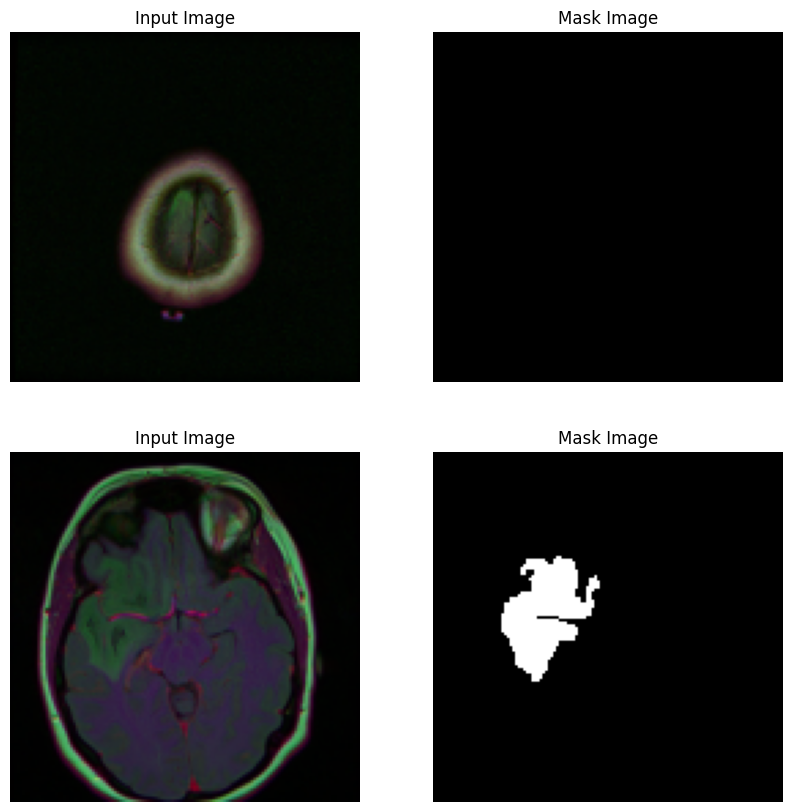

In [ ]:
# 4. Plot sample images and masks
def plot_samples(X, Y, num=2):
    plt.figure(figsize=(10, num*5))
    for i in range(num):
        plt.subplot(num, 2, 2*i+1)
        plt.imshow(X[i])
        plt.title("Input Image")
        plt.axis('off')
        plt.subplot(num, 2, 2*i+2)
        plt.imshow(Y[i].squeeze(), cmap='gray')
        plt.title("Mask Image")
        plt.axis('off')
    plt.show()

plot_samples(X_train, Y_train, num=2)


##Create model and train it

In [ ]:
# 5. U-Net model definition
def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(input_size)

    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c4)

    u5 = layers.UpSampling2D((2,2))(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D((2,2))(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2,2))(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c7)
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model(input_size=(IMG_SIZE, IMG_SIZE, 3))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 64,    │          0 │ conv2d_9[0][0]  

 Total params: 487,297 (1.86 MB)

 Trainable params: 487,297 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf

def train_model(model, X_train, Y_train, X_val, Y_val, optimizer, epochs=10):
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        batch_size=32,
        epochs=epochs,
        verbose=1
    )
    return history

# List of 5 optimizers with their names and learning rates
optimizer_configs = [
    ("Adam", tf.keras.optimizers.Adam(learning_rate=0.001)),
    ("SGD", tf.keras.optimizers.SGD(learning_rate=0.01)),
    ("RMSprop", tf.keras.optimizers.RMSprop(learning_rate=0.001)),
    ("Adagrad", tf.keras.optimizers.Adagrad(learning_rate=0.01)),
    ("Adadelta", tf.keras.optimizers.Adadelta(learning_rate=1.0)),
]

trained_models = {}   # Store trained models with optimizer name as key
histories = {}

for name, optimizer in optimizer_configs:
    print(f"\n--- Training with {name} optimizer ---\n")
    model_instance = unet_model(input_size=(IMG_SIZE, IMG_SIZE, 3))
    history = train_model(model_instance, X_train, Y_train, X_val, Y_val, optimizer, epochs=10)
    histories[name] = history
    trained_models[name] = model_instance   # Save the trained model
    print(f"{name} Final Training Accuracy:", history.history['accuracy'][-1])


--- Training with Adam optimizer ---

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_329']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.9799 - loss: 0.2260 - val_accuracy: 0.9911 - val_loss: 0.0489
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9892 - loss: 0.0370 - val_accuracy: 0.9911 - val_loss: 0.0277
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9886 - loss: 0.0286 - val_accuracy: 0.9934 - val_loss: 0.0236
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9930 - loss: 0.0230 - val_accuracy: 0.9940 - val_loss: 0.0193
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9932 - loss: 0.0216 - val_accuracy: 0.9944 - val_loss: 0.0179
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9945 - loss: 0.0173 - val_accuracy: 0.9945 - val_loss: 0.0162
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.9949 - loss: 0.0154 - val_accuracy: 0.9948 - val_loss: 0.0149
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9946 - loss: 0.0160 - val_accuracy: 0.9954 - val_los

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_354']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.8996 - loss: 0.6254 - val_accuracy: 0.9911 - val_loss: 0.4252
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9892 - loss: 0.3504 - val_accuracy: 0.9911 - val_loss: 0.0962
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.9897 - loss: 0.0822 - val_accuracy: 0.9911 - val_loss: 0.0615
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9897 - loss: 0.0670 - val_accuracy: 0.9911 - val_loss: 0.0588
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.9896 - loss: 0.0650 - val_accuracy: 0.9911 - val_loss: 0.0569
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9894 - loss: 0.0640 - val_accuracy: 0.9911 - val_loss: 0.0554
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9894 - loss: 0.0625 - val_accuracy: 0.9911 - val_loss: 0.0542
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9891 - loss: 0.0626 - val_accuracy: 0.9911 - val_loss:

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_379']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


86/86 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - accuracy: 0.9479 - loss: 0.1650 - val_accuracy: 0.9918 - val_loss: 0.0325
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.9911 - loss: 0.0313 - val_accuracy: 0.9927 - val_loss: 0.0276
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9919 - loss: 0.0278 - val_accuracy: 0.9909 - val_loss: 0.0296
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9924 - loss: 0.0251 - val_accuracy: 0.9927 - val_loss: 0.0291
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9930 - loss: 0.0241 - val_accuracy: 0.9940 - val_loss: 0.0197
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9931 - loss: 0.0220 - val_accuracy: 0.9940 - val_loss: 0.0230
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9941 - loss: 0.0190 - val_accuracy: 0.9937 - val_loss: 0.0215
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9944 - loss: 0.0176 - val_accuracy: 0.9951 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_404']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.9739 - loss: 0.3834 - val_accuracy: 0.9911 - val_loss: 0.0617
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9895 - loss: 0.0675 - val_accuracy: 0.9911 - val_loss: 0.0562
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.9891 - loss: 0.0637 - val_accuracy: 0.9911 - val_loss: 0.0511
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9897 - loss: 0.0544 - val_accuracy: 0.9911 - val_loss: 0.0428
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9892 - loss: 0.0465 - val_accuracy: 0.9911 - val_loss: 0.0377
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9892 - loss: 0.0412 - val_accuracy: 0.9911 - val_loss: 0.0337
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9887 - loss: 0.0392 - val_accuracy: 0.9911 - val_loss: 0.0329
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9889 - loss: 0.0368 - val_accuracy: 0.9911 - val_lo

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_429']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


86/86 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.9892 - loss: 0.2152 - val_accuracy: 0.9911 - val_loss: 0.0634
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9897 - loss: 0.0401 - val_accuracy: 0.9911 - val_loss: 0.0306
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9897 - loss: 0.0315 - val_accuracy: 0.9911 - val_loss: 0.0287
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9899 - loss: 0.0279 - val_accuracy: 0.9909 - val_loss: 0.0332
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9918 - loss: 0.0263 - val_accuracy: 0.9936 - val_loss: 0.0223
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9926 - loss: 0.0252 - val_accuracy: 0.9927 - val_loss: 0.0243
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9932 - loss: 0.0232 - val_accuracy: 0.9933 - val_loss: 0.0212
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9936 - loss: 0.0215 - val_accuracy: 0.9938 - val_loss:

In [ ]:
# Evaluation
def evaluate_model(model, X_test, Y_test):
    results = model.evaluate(X_test, Y_test, verbose=0)
    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")
    return results

evaluation_results = {}
for name, model_instance in trained_models.items():
    print(f"\nEvaluating model with {name} optimizer:")
    results = evaluate_model(model_instance, X_test, Y_test)
    evaluation_results[name] = {
        "Test Loss": results[0],
        "Test Accuracy": results[1]
    }


Evaluating model with Adam optimizer:
Test Loss: 0.0144
Test Accuracy: 0.9950

Evaluating model with SGD optimizer:
Test Loss: 0.0559
Test Accuracy: 0.9899

Evaluating model with RMSprop optimizer:
Test Loss: 0.0125
Test Accuracy: 0.9955

Evaluating model with Adagrad optimizer:
Test Loss: 0.0307
Test Accuracy: 0.9899

Evaluating model with Adadelta optimizer:
Test Loss: 0.0177
Test Accuracy: 0.9945


## Plot the histories and resulets

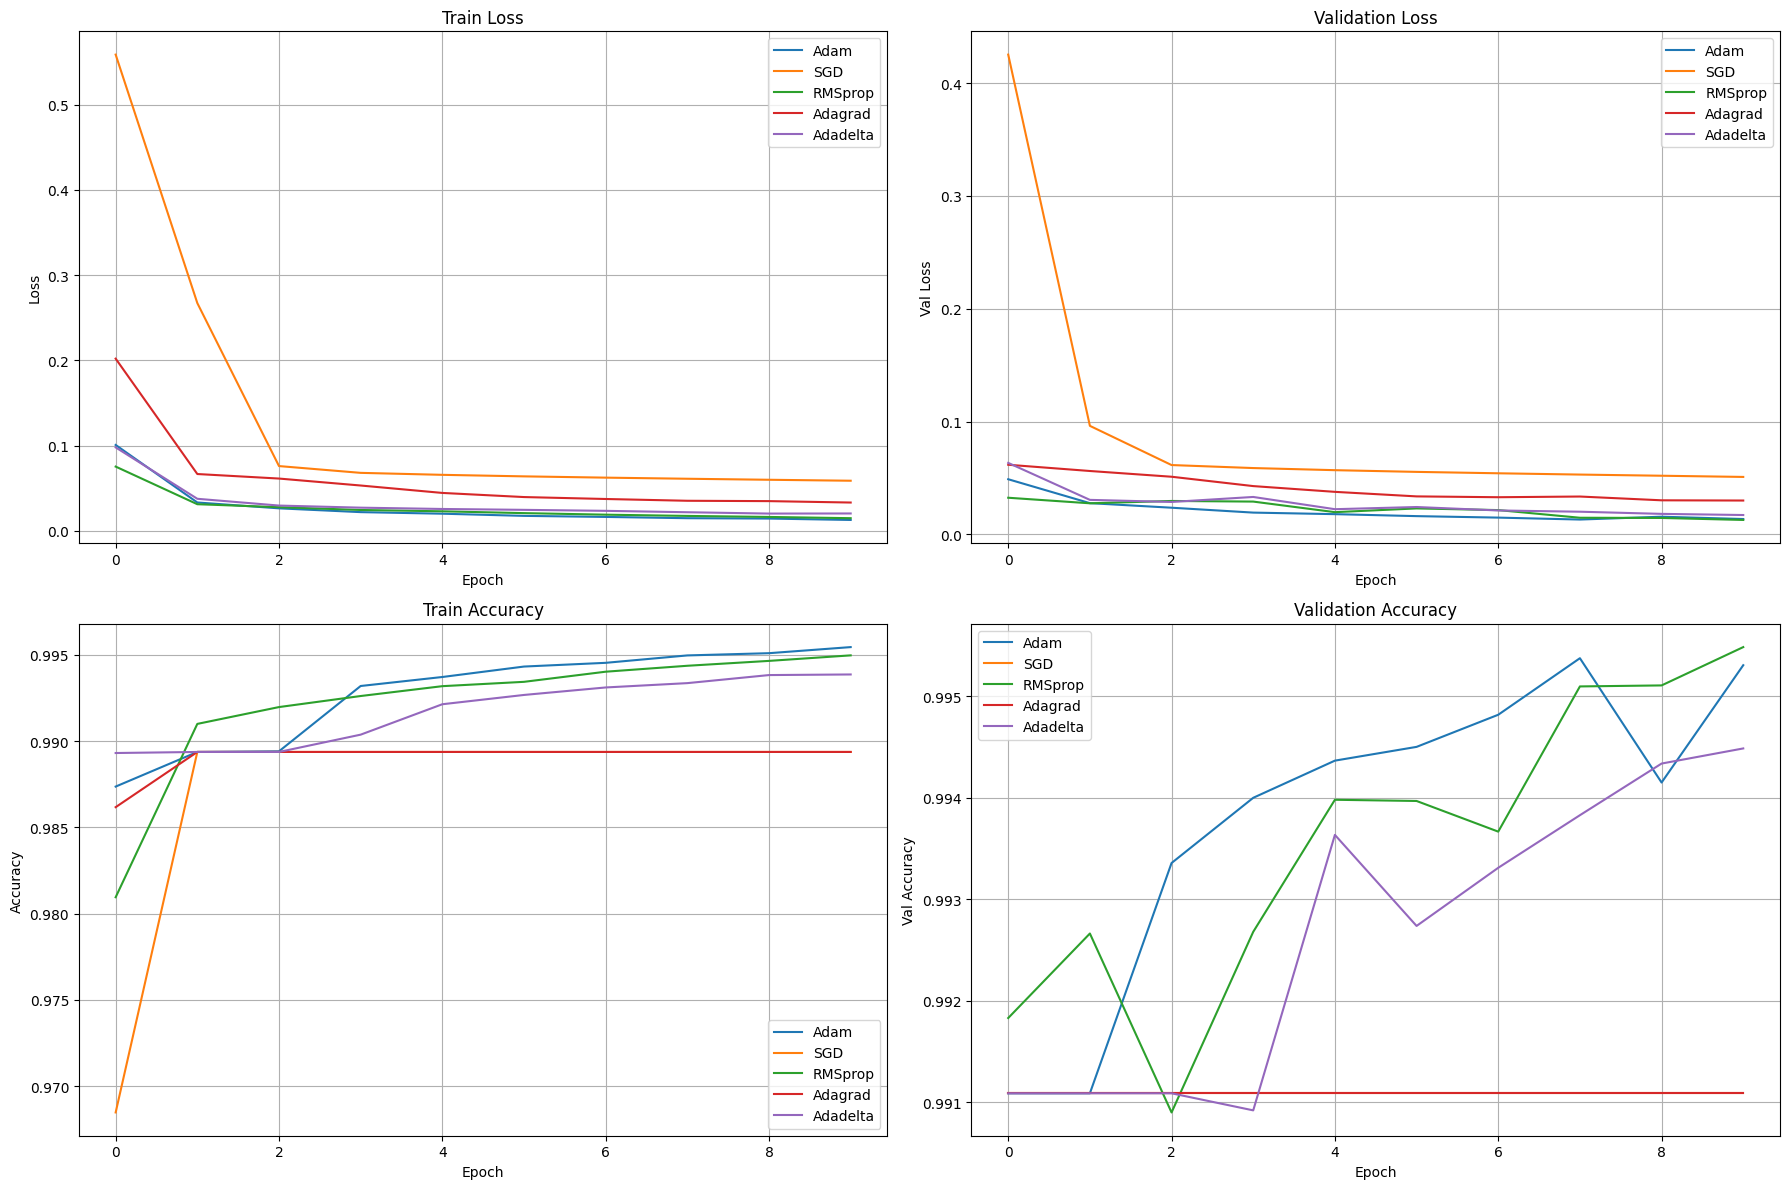

In [ ]:
import matplotlib.pyplot as plt

# 1. Plotting Figures
def plot_training_curves(histories):
    plt.figure(figsize=(18, 12))

    # Figure-1: Train loss
    plt.subplot(2, 2, 1)
    for name, history in histories.items():
        plt.plot(history.history['loss'], label=f'{name}')
    plt.title('Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Figure-2: Validation loss
    plt.subplot(2, 2, 2)
    for name, history in histories.items():
        plt.plot(history.history['val_loss'], label=f'{name}')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Val Loss')
    plt.legend()
    plt.grid(True)

    # Figure-3: Train accuracy
    plt.subplot(2, 2, 3)
    for name, history in histories.items():
        plt.plot(history.history['accuracy'], label=f'{name}')
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Figure-4: Validation accuracy
    plt.subplot(2, 2, 4)
    for name, history in histories.items():
        plt.plot(history.history['val_accuracy'], label=f'{name}')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Val Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_curves(histories)

In [ ]:
# 2. Print Summary Table
print("\nSummary of Results (Final Epoch):\n")
print("{:<10} {:<12} {:<12} {:<12} {:<15} {:<15}".format(
    "Model", "Optimizer", "Train Loss", "Train Acc", "Val/Test Loss", "Val/Test Acc"
))
print("-" * 76)
for name, history in histories.items():
    train_loss = history.history['loss'][-1]
    train_acc = history.history['accuracy'][-1]
    val_loss = history.history['val_loss'][-1]
    val_acc = history.history['val_accuracy'][-1]
    # Use test results if available
    if name in evaluation_results:
        val_loss = evaluation_results[name]["Test Loss"]
        val_acc = evaluation_results[name]["Test Accuracy"]
    print("{:<10} {:<12} {:<12.4f} {:<12.4f} {:<15.4f} {:<15.4f}".format(
        "U-Net", name, train_loss, train_acc, val_loss, val_acc
    ))


Summary of Results (Final Epoch):

Model      Optimizer    Train Loss   Train Acc    Val/Test Loss   Val/Test Acc   
----------------------------------------------------------------------------
U-Net      Adam         0.0128       0.9954       0.0144          0.9950         
U-Net      SGD          0.0588       0.9894       0.0559          0.9899         
U-Net      RMSprop      0.0149       0.9950       0.0125          0.9955         
U-Net      Adagrad      0.0332       0.9894       0.0307          0.9899         
U-Net      Adadelta     0.0204       0.9939       0.0177          0.9945         
